In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/processed/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [4]:
df.isna().sum()

Passengers    0
dtype: int64

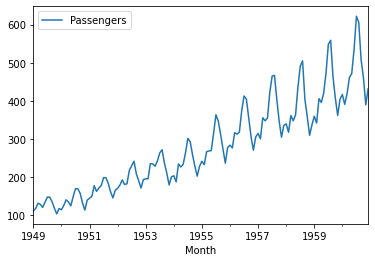

In [5]:
df.plot();

In [6]:
alpha = 0.2

In [7]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [9]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

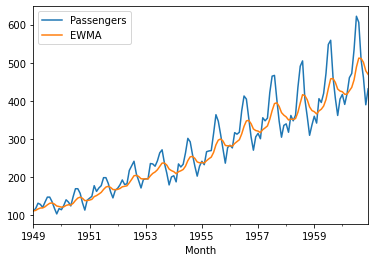

In [10]:
df.plot();

In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual'] = manual_ewma

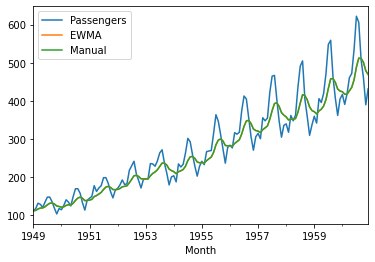

In [12]:
df.plot();

In [13]:
df.head()

Passengers      EWMA    Manual
Month                                     
1949-01-01         112  112.0000  112.0000
1949-02-01         118  113.2000  113.2000
1949-03-01         132  116.9600  116.9600
1949-04-01         129  119.3680  119.3680
1949-05-01         121  119.6944  119.6944

In [14]:
df.drop('Manual', axis=1, inplace=True)

# Holt- Winters

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
ses = SimpleExpSmoothing(df['Passengers'])

In [17]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [18]:
df.index.freq = 'MS'

In [19]:
ses = SimpleExpSmoothing(df['Passengers'])


In [20]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [21]:
res

In [22]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [24]:
np.allclose(df['SES'], res.fittedvalues)

True

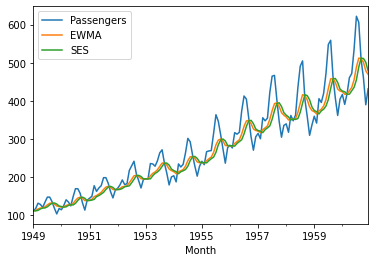

In [25]:
df.plot();

In [26]:
df.head()

Passengers      EWMA      SES
Month                                    
1949-01-01         112  112.0000  112.000
1949-02-01         118  113.2000  112.000
1949-03-01         132  116.9600  113.200
1949-04-01         129  119.3680  116.960
1949-05-01         121  119.6944  119.368

In [27]:
df['SES-1'] = df['SES'].shift(-1)

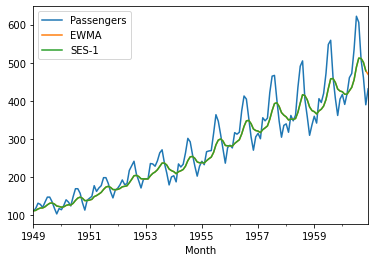

In [28]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [29]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [30]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

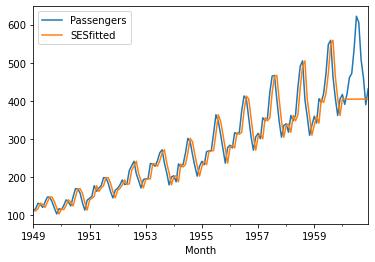

In [31]:
df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [32]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [33]:
from statsmodels.tsa.holtwinters import Holt

In [34]:
holt = Holt(df['Passengers'])

In [35]:
res_h = holt.fit()

In [36]:
df['Holt'] = res_h.fittedvalues

<AxesSubplot:xlabel='Month'>

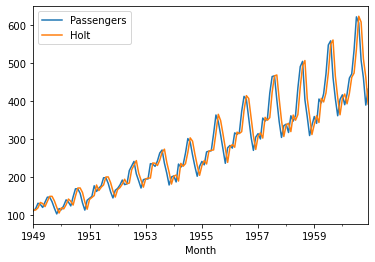

In [37]:
df[['Passengers', 'Holt']].plot()


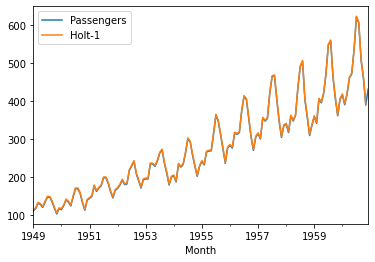

In [38]:
## No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();


In [41]:
holt = Holt(train['Passengers'])
res_h =holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues

In [42]:
df.loc[-N_test:,'Holt'] = res_h.forecast(N_test)

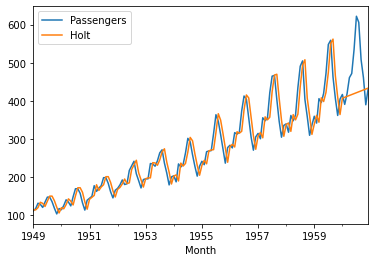

In [43]:
df[['Passengers', 'Holt']].plot();